In [1]:
import numpy
import keras
from keras.models import Sequential
from keras.layers import Activation, GlobalAveragePooling2D
from keras.layers.core import Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from vis.visualization import visualize_cam
import itertools
import os

Using TensorFlow backend.


In [2]:
root_path = r"c:\Data\z1"

train_path = os.path.join(root_path, "train")
valid_path = os.path.join(root_path, "valid")
test_path = os.path.join(root_path, "test")

In [3]:
image_size = 64
train_batch_size = 100

train_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(
    train_path,
    target_size=(image_size, image_size),
    color_mode='grayscale',
    classes=["pos", "neg"],
    shuffle=True,
    batch_size=train_batch_size)

valid_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(
    valid_path,
    target_size=(image_size, image_size),
    color_mode='grayscale',
    classes=["pos", "neg"],
    shuffle=True,
    batch_size=train_batch_size)

test_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_path,
    target_size=(image_size, image_size),
    color_mode='grayscale',
    classes=["pos", "neg"],
    shuffle=True)

test_batches.batch_size = test_batches.n
x_test, y_test = next(test_batches)
print("x_test.shape: {}".format(x_test.shape))
print("y_test.shape: {}".format(y_test.shape))

Found 1961 images belonging to 2 classes.
Found 242 images belonging to 2 classes.
Found 241 images belonging to 2 classes.
x_test.shape: (241, 64, 64, 1)
y_test.shape: (241, 2)


In [4]:
def plots(ims, figsize=(20,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis("Off")
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i][:, :, 0], cmap='gray')

In [5]:
# imgs, labels = next(train_batches)
# plots(imgs[:10], titles=labels[:10])

In [6]:

model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(image_size, image_size, 1)))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(image_size, image_size, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(.25))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
# model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(.25))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(.25))

model.add(GlobalAveragePooling2D())

# model.add(Flatten())
# model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))


In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
__________

In [8]:
model.compile(Adam(lr=.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
history = model.fit_generator(
    train_batches,
    steps_per_epoch=train_batches.n // train_batch_size,
    validation_data=valid_batches,
    validation_steps=valid_batches.n // train_batch_size,
    epochs=20,
    verbose=1)

Epoch 1/20
19/19 [==============================] - 6s 327ms/step - loss: 0.6475 - acc: 0.6421 - val_loss: 0.6341 - val_acc: 0.6850
Epoch 2/20
19/19 [==============================] - 4s 213ms/step - loss: 0.6400 - acc: 0.6587 - val_loss: 0.6697 - val_acc: 0.6197
Epoch 3/20
19/19 [==============================] - 4s 203ms/step - loss: 0.6461 - acc: 0.6601 - val_loss: 0.6562 - val_acc: 0.6972
Epoch 4/20
19/19 [==============================] - 4s 207ms/step - loss: 0.6426 - acc: 0.6684 - val_loss: 0.6426 - val_acc: 0.6600
Epoch 5/20
19/19 [==============================] - 4s 206ms/step - loss: 0.6419 - acc: 0.6565 - val_loss: 0.6382 - val_acc: 0.6690
Epoch 6/20
19/19 [==============================] - 4s 207ms/step - loss: 0.6445 - acc: 0.6510 - val_loss: 0.6324 - val_acc: 0.6831
Epoch 7/20
19/19 [==============================] - 4s 206ms/step - loss: 0.6291 - acc: 0.6717 - val_loss: 0.6323 - val_acc: 0.6600
Epoch 8/20
19/19 [==============================] - 4s 206ms/step - loss: 0.

Text(0.5,1,'Accuracy Curves')

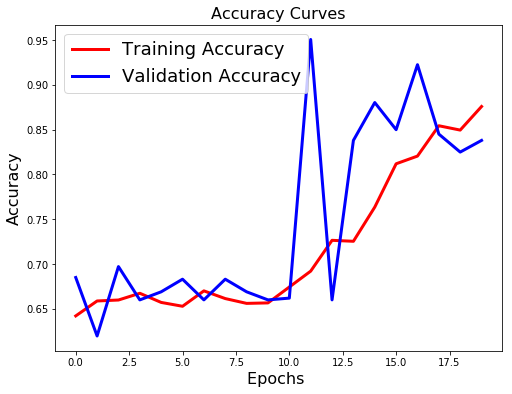

In [10]:
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [11]:
score = model.evaluate(x_test, y_test, verbose=0)
score[1]

0.7925311208265946

In [12]:
y_pred = model.predict_classes(x_test)
acc = sum([y_test[i,1]==y_pred[i] for i in range(test_batches.n)]) / test_batches.n
print("Accuracy = {:.2f}%".format(acc))

Accuracy = 0.79%


[0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 1 0]
[1 1 1 1 0 1 0 1 0 0 1 0 0 1 1 1 0 1 0 1 1 1 1 1 1 0 1 0 1 0]


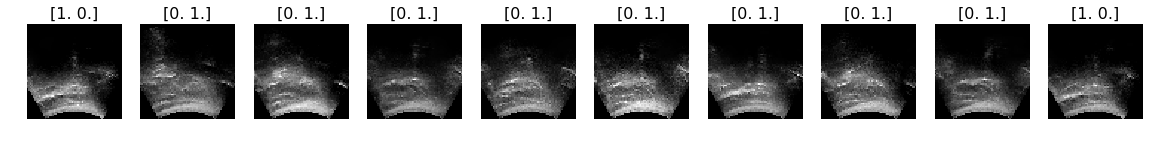

In [13]:
print(y_test[:30,1].astype(int))
print(y_pred[:30])
plots(x_test[:10], titles=y_test[:10])

In [14]:
import pandas as pd
y_t = pd.Series(y_test[:,1])
y_p = pd.Series(y_pred)
pd.crosstab(y_t, y_p, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0.0,60,21,81
1.0,29,131,160
All,89,152,241


In [15]:
len(model.layers)

14

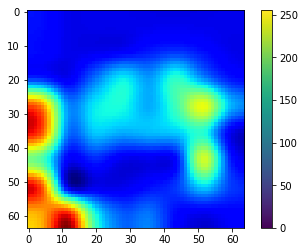

In [26]:
heat_map = visualize_cam(model, 12, None, x_test[9])

plt.imshow(heat_map)
out = plt.colorbar()